In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Projekt-Root automatisch finden
PROJECT_ROOT = next(p for p in Path.cwd().parents if (p / "project/Computer-Vision-FCH").exists())

# CSV laden
CSV = PROJECT_ROOT / "project/Computer-Vision-FCH/analytics/frame_events_4_30.csv"
df = pd.read_csv(CSV)

# Pitch-Bild laden
pitch_path = PROJECT_ROOT / "project/Computer-Vision-FCH/calibration/pictures/fch_fussballfeld.jpg"
pitch_img = Image.open(pitch_path)

pitch_length = 100   # Meter
pitch_width = 60

# Match-Statistiken

## Ball-Heatmap

**Was zeigt sie?**  
Die Ball-Heatmap zeigt, wo auf dem Spielfeld der Ball am häufigsten war.  
Helle Bereiche = viele Frames mit Ball dort.

**Wofür gut?**
- Erkennen, wo das Spiel stattfindet  
- Identifikation von Pressing-Zonen  
- Analyse, ob der Ball überwiegend zentral oder seitlich geführt wurde


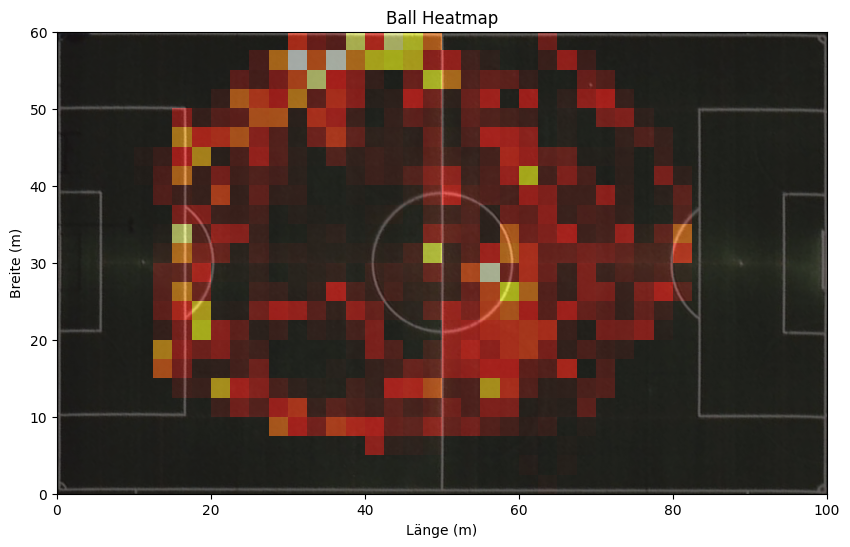

In [137]:
mask = (df["ball_visible"] == 1) & df["ball_x_m"].notna() & df["ball_y_m"].notna()
ball_x = df.loc[mask, "ball_x_m"].to_numpy()
ball_y = df.loc[mask, "ball_y_m"].to_numpy()

H, _, _ = np.histogram2d(
    ball_x,
    ball_y,
    bins=[40, 24],
    range=[[0, pitch_length], [0, pitch_width]]
)

plt.figure(figsize=(10, 6))

plt.imshow(pitch_img, extent=[0, pitch_length, 0, pitch_width], aspect="equal")
plt.imshow(H.T, origin="lower", extent=[0, pitch_length, 0, pitch_width],
           cmap="hot", alpha=0.55)

plt.title("Ball Heatmap")
plt.xlabel("Länge (m)")
plt.ylabel("Breite (m)")
plt.show()

## Heatmaps für Ballbesitz Team 1 & Team 2
**Was zeigt sie?**  
Zwei Heatmaps gleichzeitig:
- Heatmap für Team 1, nur während Team 1 in Ballbesitz war  
- Heatmap für Team 2, nur während Team 2 in Ballbesitz war

**Wofür gut?**
- Taktische Unterschiede zwischen den Teams erkennen  
- Team 1 baut vielleicht geduldig hinten auf  
- Team 2 spielt vielleicht besonders über die Aussen

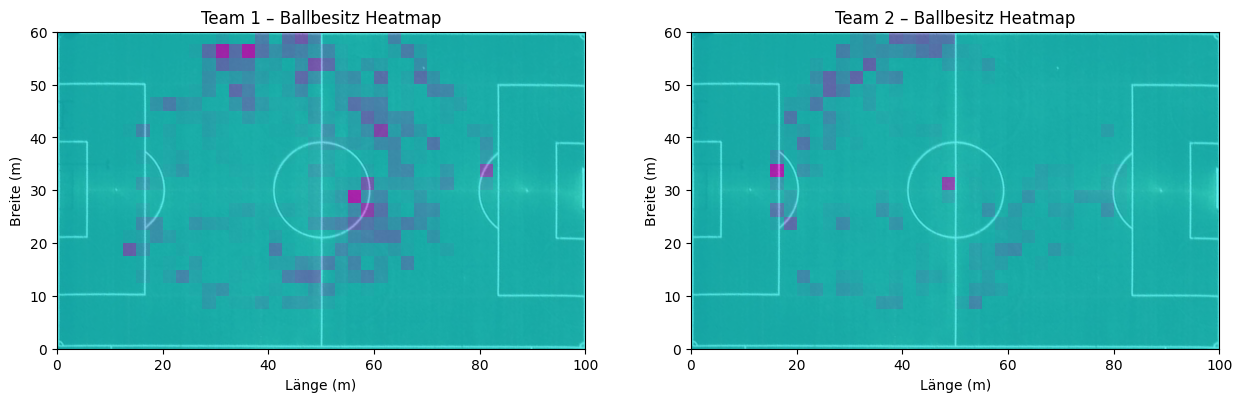

In [138]:
mask = df["ball_x_m"].notna()

t1_x = df.loc[mask & (df["team_ball_control"] == 1), "ball_x_m"]
t1_y = df.loc[mask & (df["team_ball_control"] == 1), "ball_y_m"]

t2_x = df.loc[mask & (df["team_ball_control"] == 2), "ball_x_m"]
t2_y = df.loc[mask & (df["team_ball_control"] == 2), "ball_y_m"]

fig, axes = plt.subplots(1, 2, figsize=(15,6))

for ax, x, y, title in [
    (axes[0], t1_x, t1_y, "Team 1 – Ballbesitz Heatmap"),
    (axes[1], t2_x, t2_y, "Team 2 – Ballbesitz Heatmap")
]:
    H, _, _ = np.histogram2d(x, y, bins=[40,24], range=[[0, pitch_length], [0, pitch_width]])

    ax.imshow(pitch_img, extent=[0, pitch_length, 0, pitch_width], aspect="equal")
    ax.imshow(H.T, origin="lower", extent=[0, pitch_length, 0, pitch_width],
              cmap="cool", alpha=0.55)
    ax.set_title(title)
    ax.set_xlabel("Länge (m)")
    ax.set_ylabel("Breite (m)")

plt.show()

## Rolling Ball Possession (10s Fenster)

**Was zeigt sie?**  
Eine Zeitreihe, die anzeigt, wie viel Ballbesitz (%) jedes Team in den letzten 10 Sekunden hatte.

**Wofür gut?**
- Momentum-Grafik  
- Druckphasen erkennen  
- Sehen, wann ein Team dominiert oder unter Druck gerät  

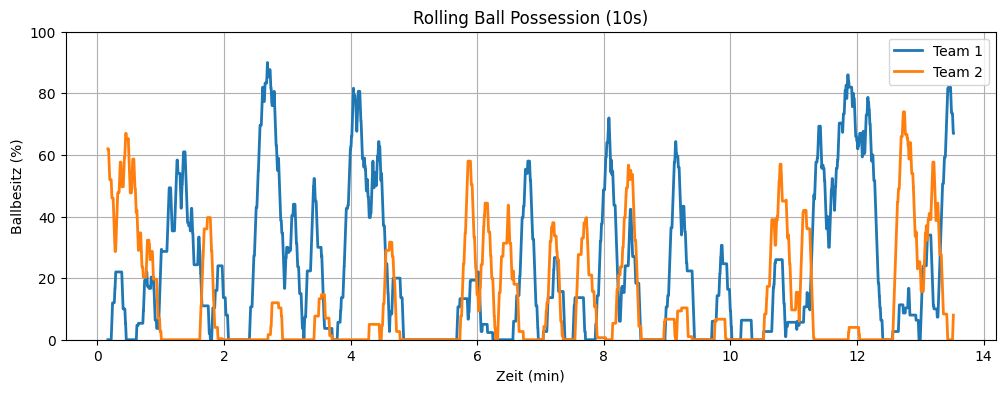

In [143]:
ctrl = df["team_ball_control"]

dt = df["time_sec"].diff().median()
window_frames = int(10 / dt)

is_t1 = (ctrl == 1).astype(float)
is_t2 = (ctrl == 2).astype(float)

roll_t1 = is_t1.rolling(window_frames).mean()
roll_t2 = is_t2.rolling(window_frames).mean()

time_min = df["time_sec"] / 60

plt.figure(figsize=(12,4))
plt.plot(time_min, roll_t1 * 100, label="Team 1", linewidth=2)
plt.plot(time_min, roll_t2 * 100, label="Team 2", linewidth=2)

plt.title("Rolling Ball Possession (10s)")
plt.xlabel("Zeit (min)")
plt.ylabel("Ballbesitz (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()

## xBall Progression

**Was zeigt sie?**  
Wie viele Meter jedes Team den Ball Richtung gegnerisches Tor bewegt hat.

**Zwei Darstellungen:**
- Gesamtwert (z. B. „Team 1: +238 m“)  
- Kumulierte Feldgewinn-Kurve über das Spiel

**Wofür gut?**
- Zeigt echte Durchschlagskraft statt nur Ballbesitz  
- Unterschied zwischen „Ball halten“ und „Ball nach vorne bringen“

xBall Progression:
 Team 1: +-90.1 m
 Team 2: +-79.3 m


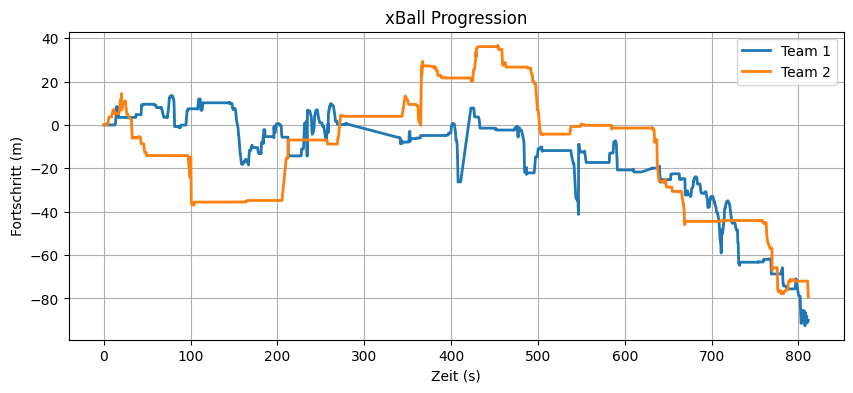

In [144]:
mask = df["ball_x_m"].notna()

x = df.loc[mask, "ball_x_m"].to_numpy()
t = df.loc[mask, "time_sec"].to_numpy()
ctrl = df.loc[mask, "team_ball_control"].to_numpy()

dx = np.diff(x)
t_mid = t[1:]
ctrl_mid = ctrl[1:]

progress_t1 = dx[ctrl_mid == 1].sum()
progress_t2 = -dx[ctrl_mid == 2].sum()

print("xBall Progression:")
print(f" Team 1: +{progress_t1:.1f} m")
print(f" Team 2: +{progress_t2:.1f} m")

cum_t1 = np.cumsum(np.where(ctrl_mid == 1, dx, 0))
cum_t2 = np.cumsum(np.where(ctrl_mid == 2, -dx, 0))

plt.figure(figsize=(10,4))
plt.plot(t_mid, cum_t1, label="Team 1", linewidth=2)
plt.plot(t_mid, cum_t2, label="Team 2", linewidth=2)
plt.title("xBall Progression")
plt.xlabel("Zeit (s)")
plt.ylabel("Fortschritt (m)")
plt.grid(True)
plt.legend()
plt.show()

## Zonenanalyse (Defensiv – Mittelfeld – Offensiv)

**Was zeigt sie?**  
Das Spielfeld wird in 3 Längszonen geteilt:
- Defensiv (0–33 m)  
- Mittelfeld (33–66 m)  
- Offensiv (66–100 m)

**Der Algorithmus misst:**
- Wie viel Prozent des Spiels der Ball in jeder Zone war  
- Pro Team (nur während eigener Ballkontrolle)

**Wofür gut?**
- Erkennen, welches Team mehr im Angriffsdrittel war  
- Spielkontrolle sichtbar machen  
- Spielweise analysieren (z. B. tief stehen vs. hoher Druck)

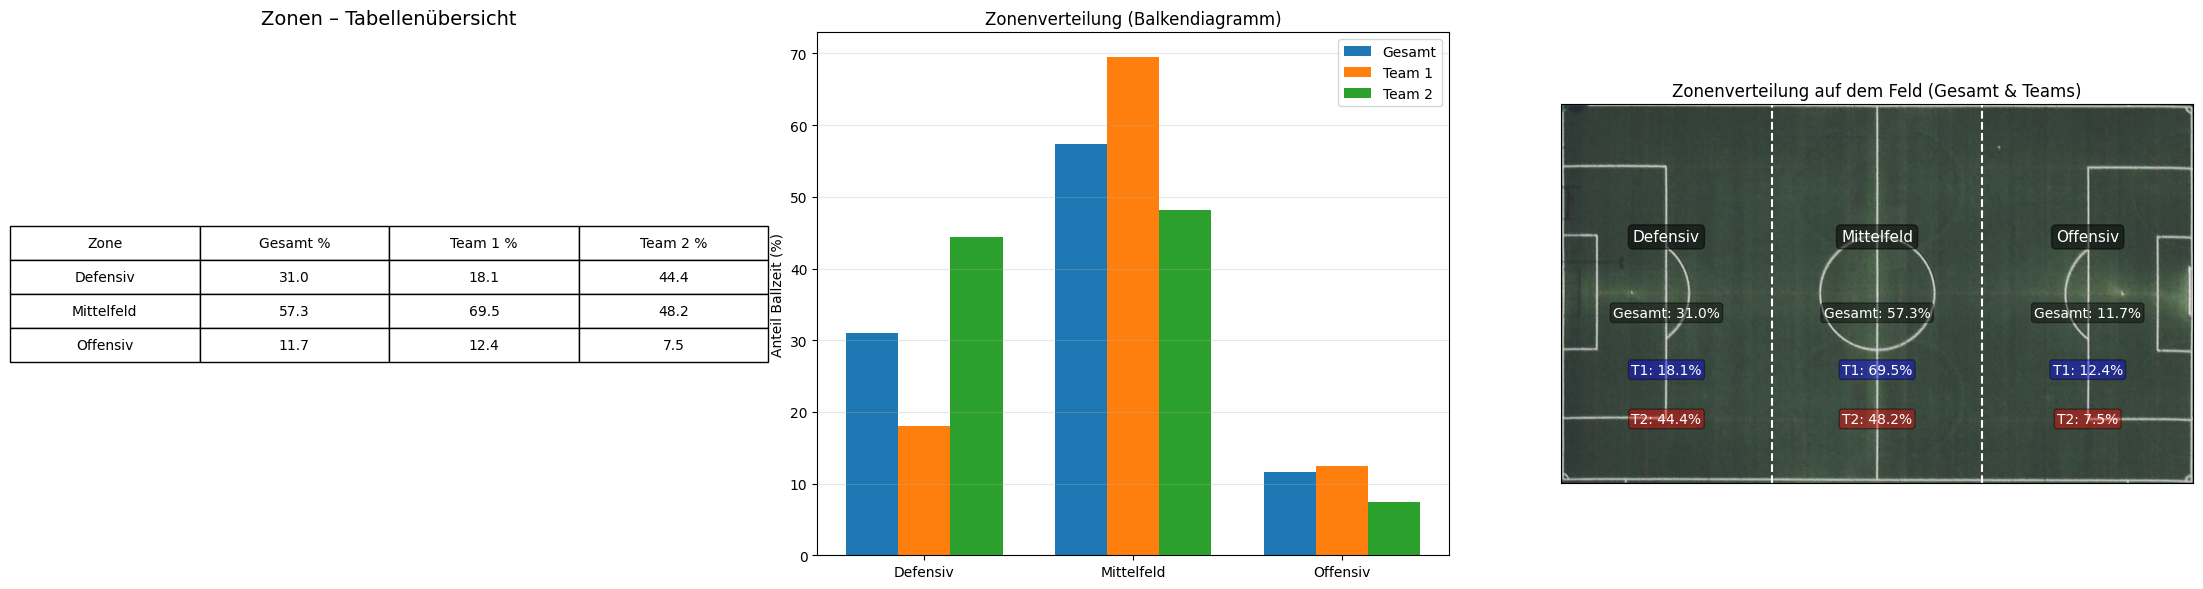

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Zonenlogik
# -----------------------
L = pitch_length  # z.B. 100m
zones = ["Defensiv", "Mittelfeld", "Offensiv"]

def zone(x):
    if x < L/3: return "Defensiv"
    if x < 2*L/3: return "Mittelfeld"
    return "Offensiv"

mask = df["ball_x_m"].notna()
df_z = df.loc[mask].copy()
df_z["zone"] = df_z["ball_x_m"].apply(zone)

def zone_percentages(sub):
    counts = sub["zone"].value_counts(normalize=True)
    return [counts.get(z, 0) * 100 for z in zones]

# Prozentwerte
total_pct = zone_percentages(df_z)
t1_pct = zone_percentages(df_z[df_z["team_ball_control"] == 1])
t2_pct = zone_percentages(df_z[df_z["team_ball_control"] == 2])

# -----------------------
# NEBENEINANDER: 3 Plots
# -----------------------
fig, axes = plt.subplots(1, 3, figsize=(22,6))

# ----------------------------------------
# 1) Text-Ausgabe als Tabelle (links)
# ----------------------------------------
ax = axes[0]
ax.axis("off")

table_data = [
    ["Zone", "Gesamt %", "Team 1 %", "Team 2 %"],
    [zones[0], f"{total_pct[0]:.1f}", f"{t1_pct[0]:.1f}", f"{t2_pct[0]:.1f}"],
    [zones[1], f"{total_pct[1]:.1f}", f"{t1_pct[1]:.1f}", f"{t2_pct[1]:.1f}"],
    [zones[2], f"{total_pct[2]:.1f}", f"{t1_pct[2]:.1f}", f"{t2_pct[2]:.1f}"],
]

table = ax.table(
    cellText=table_data,
    loc="center",
    cellLoc="center",
)
table.scale(1.2, 1.8)
ax.set_title("Zonen – Tabellenübersicht", fontsize=14)

# ----------------------------------------
# 2) Balkendiagramm (Mitte)
# ----------------------------------------
ax = axes[1]

x = np.arange(len(zones))
width = 0.25

ax.bar(x - width, total_pct, width, label="Gesamt")
ax.bar(x,         t1_pct,    width, label="Team 1")
ax.bar(x + width, t2_pct,    width, label="Team 2")

ax.set_xticks(x, zones)
ax.set_ylabel("Anteil Ballzeit (%)")
ax.set_title("Zonenverteilung (Balkendiagramm)")
ax.grid(axis="y", alpha=0.3)
ax.legend()

# ----------------------------------------
# 3) Pitch-Visualisierung – für beide Teams (rechts)
# ----------------------------------------
ax = axes[2]

ax.imshow(pitch_img, extent=[0, L, 0, pitch_width], aspect="equal")

# Zonen-Grenzen
ax.axvline(L/3, linestyle="--", color="white")
ax.axvline(2*L/3, linestyle="--", color="white")

# Textblock pro Zone: Gesamt / Team 1 / Team 2
for i, name in enumerate(zones):
    x_center = (i + 0.5) * (L/3)

    # Gesamt
    ax.text(
        x_center,
        pitch_width * 0.65,
        f"{name}",
        ha="center",
        va="center",
        fontsize=11,
        color="white",
        bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.3")
    )

    ax.text(
        x_center,
        pitch_width * 0.45,
        f"Gesamt: {total_pct[i]:.1f}%",
        ha="center",
        va="center",
        fontsize=10,
        color="white",
        bbox=dict(facecolor="black", alpha=0.4, boxstyle="round,pad=0.2")
    )

    ax.text(
        x_center,
        pitch_width * 0.30,
        f"T1: {t1_pct[i]:.1f}%",
        ha="center",
        va="center",
        fontsize=10,
        color="white",
        bbox=dict(facecolor="blue", alpha=0.4, boxstyle="round,pad=0.2")
    )

    ax.text(
        x_center,
        pitch_width * 0.17,
        f"T2: {t2_pct[i]:.1f}%",
        ha="center",
        va="center",
        fontsize=10,
        color="white",
        bbox=dict(facecolor="red", alpha=0.4, boxstyle="round,pad=0.2")
    )

ax.set_xlim(0, L)
ax.set_ylim(0, pitch_width)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Zonenverteilung auf dem Feld (Gesamt & Teams)")

plt.tight_layout()
plt.show()

## Druckphasen

Druckphasen Team 1 – Frames: 0
Druckphasen Team 2 – Frames: 64


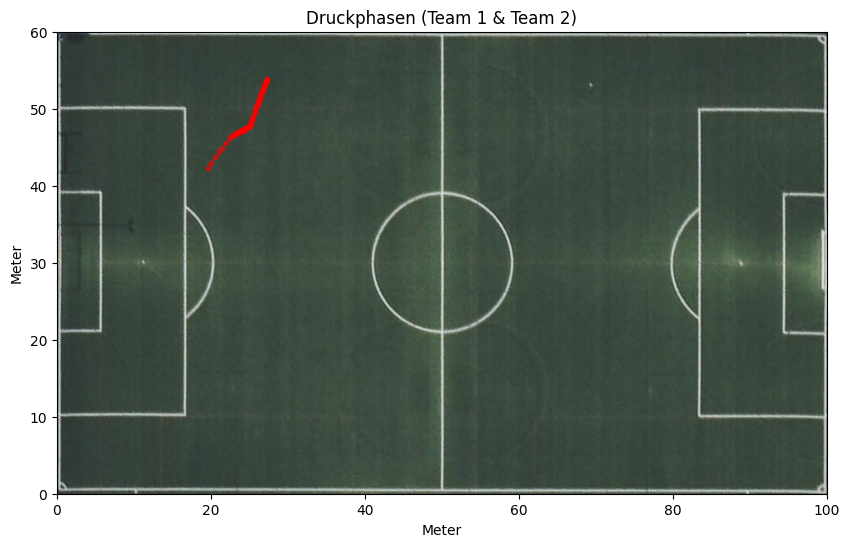

In [146]:
# Rolling Possession
dt = df["time_sec"].diff().median()
window_sec = 10
window_frames = int(window_sec / dt)

is_t1 = (df["team_ball_control"] == 1).astype(float)
is_t2 = (df["team_ball_control"] == 2).astype(float)

roll_t1 = is_t1.rolling(window_frames, min_periods=1).mean()
roll_t2 = is_t2.rolling(window_frames, min_periods=1).mean()

# Druckphase: > 70% Ballbesitz + Ball tief im gegnerischen Drittel
defensive_third = (df["ball_x_m"] >= pitch_length * (2/3))  # Team 1 Angriff

pressure_t1 = (roll_t1 > 0.7) & defensive_third
pressure_t2 = (roll_t2 > 0.7) & (df["ball_x_m"] <= pitch_length * (1/3))

print("Druckphasen Team 1 – Frames:", pressure_t1.sum())
print("Druckphasen Team 2 – Frames:", pressure_t2.sum())

mask = pressure_t1 | pressure_t2

px = df.loc[mask, "ball_x_m"].to_numpy()
py = df.loc[mask, "ball_y_m"].to_numpy()

plt.figure(figsize=(10,6))
plt.imshow(pitch_img, extent=[0, pitch_length, 0, pitch_width], aspect="equal")

plt.scatter(px, py, s=10, c="red", alpha=0.6)

plt.title("Druckphasen (Team 1 & Team 2)")
plt.xlabel("Meter")
plt.ylabel("Meter")
plt.show()

## Umschaltphasen

Anzahl Besitz-Segmente (inkl. 0): 516
Echte Umschaltmomente (>= 9 & 9 Frames je Team): 17


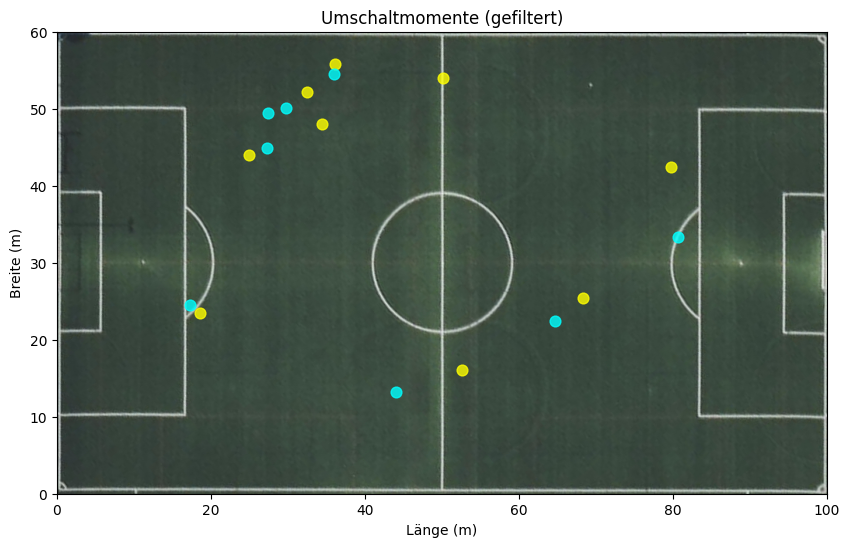

In [147]:
ctrl = df["team_ball_control"].to_numpy()
time = df["time_sec"].to_numpy()
x = df["ball_x_m"].to_numpy()
y = df["ball_y_m"].to_numpy()

n = len(ctrl)
segments = []
if n > 0:
    cur_team = ctrl[0]
    start_idx = 0
    for i in range(1, n):
        if ctrl[i] != cur_team:
            segments.append((cur_team, start_idx, i-1))
            cur_team = ctrl[i]
            start_idx = i
    segments.append((cur_team, start_idx, n-1))

print("Anzahl Besitz-Segmente (inkl. 0):", len(segments))

MIN_FRAMES_PREV = 9
MIN_FRAMES_NEXT = 9

transitions = []

for i in range(1, len(segments)):
    team_prev, s0, e0 = segments[i-1]
    team_next, s1, e1 = segments[i]

    if team_prev not in (1,2) or team_next not in (1,2):
        continue
    if team_prev == team_next:
        continue

    len_prev = e0 - s0 + 1
    len_next = e1 - s1 + 1

    if len_prev < MIN_FRAMES_PREV or len_next < MIN_FRAMES_NEXT:
        continue

    idx = s1  # erster Frame der neuen Ballkontrolle
    if not np.isfinite(x[idx]) or not np.isfinite(y[idx]):
        continue

    transitions.append({
        "time": float(time[idx]),
        "from_team": int(team_prev),
        "to_team": int(team_next),
        "x": float(x[idx]),
        "y": float(y[idx]),
        "frames_prev": int(len_prev),
        "frames_next": int(len_next),
    })

print(f"Echte Umschaltmomente (>= {MIN_FRAMES_PREV} & {MIN_FRAMES_NEXT} Frames je Team): {len(transitions)}")

plt.figure(figsize=(10,6))
plt.imshow(pitch_img, extent=[0, pitch_length, 0, pitch_width], aspect="equal")

for ev in transitions:
    c = "cyan" if ev["to_team"] == 1 else "yellow"
    plt.scatter(ev["x"], ev["y"], color=c, s=60, alpha=0.8)

plt.title("Umschaltmomente (gefiltert)")
plt.xlabel("Länge (m)")
plt.ylabel("Breite (m)")
plt.show()